<a href="https://colab.research.google.com/github/Hing-9/popup_store/blob/main/Popup_Store_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "효과적인 팝업스토어 연계를 위한 정보 제공방안 연구" Flow Chart.
##1. Transformer를 활용하여 NER로 1차 추출
- 사용 모델 : "monologg/koelectra-base-v3-naver-ner"
- 추가적으로 AI-Hub의 구어체 데이터 사용할 것인지 생각
- 어떤 Tag까지 브랜드 명으로 볼건지 확인

##2. ChatGPT API를 활용하여 2차 추출
- NER로 추출한 후보군 및 전체 context를 입력하여 Quest-Answer로 보정
- 적절한 Prompt 구성이 중요

###====================================

- 여기까지 "브랜드명", "판매품목", "위치", "기간"을 추출
- 사람이 마지막으로 최종 결정을 내리는 것으로

###====================================

##3. 브랜드명으로 감성분석 진행
- Naver Cloud AI 참조

##4. Kakao API로 해당 위치의 정보를 추출
- 기본적으로 주변 지하철 정보, 비슷한 업종의 분포
- 공공데이터로 인구이동정보, 교통정보

##5. 오픈기간의 시계열 정보를 활용
- 날씨, 계절

#환경설정

## Library Download

In [ ]:
!pip install transformers
!pip install openai
!pip install PyKakao
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python

## Library Import

In [ ]:
import pandas as pd
import numpy as np
import re
import ast
import json
from tqdm import tqdm
import time

from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel, pipeline
import torch
import openai

from difflib import SequenceMatcher
from datetime import datetime

from PyKakao import Local
from haversine import haversine

# 경고문구 주석처리
import warnings
warnings.filterwarnings(action='ignore')

## Google Drive Connect

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Graduation-Thesis/NER

Mounted at /content/drive
/content/drive/MyDrive/Graduation-Thesis/NER


## 데이터 Load

In [ ]:
dataset = pd.read_csv("main_df.csv", index_col=0, sep="|").dropna()
dataset

,url,content,date
0,https://www.instagram.com/p/Cs5bRHjv8a-/,⏰ 팝가가 미리 알려주는 “업커밍 팝업스토어”⏰\n\n📝 Dr. GOT YOU 팝업...,2023-05-31
1,https://www.instagram.com/p/CqejZt2Bfym/,💌4월 첫째 주 핫한 팝업 모음. zip💌\n\n✔️한달만 고깃집\n📍강남구 선릉로...,2023-04-01
2,https://www.instagram.com/p/BwbZqTJgeID/,4/19~4/28 봄캠핑대전 in 벨라시타\n\n캠핑족을 부르는 캠핑대전 특가 팝업...,2019-04-19
3,https://www.instagram.com/p/CYJKwfLpbC4/,🔥@yoonj_u 가 다녀오라고 했다! 르르르 하우스의 생생한 후기를 전하는 내발내...,2022-01-03
4,https://www.instagram.com/p/CqehHInBwA7/,"🥓한달만 고깃집 팝업스토어🥓\n\nSNS 맛집 인플루언서, 피그웨이브와 꿉당이 만든...",2023-04-01
...,...,...,...
882,https://www.instagram.com/p/CKdkXlKJ619/,달콤한 코랄핑크🎉치명적 귀여움 🎊무유무유\n\n다꾸의 일인자 무유무유가 돌아왔다! ...,2021-01-25
883,https://www.instagram.com/p/B1a13jtJmsG/,#아슬란팝업스토어\n\n전국에 있는 빵덕후들 울산으로 다 모이는 소식😋🥖\n아슬란 ...,2019-08-21
884,https://www.instagram.com/p/BzVbG6-AObv/,6/28~7/14 아크메드라비 in 롯데백화점 본점\n\n합리적인 가격의 브랜드 아...,2019-06-30
885,https://www.instagram.com/p/BvNhjQDA7Mq/,3/15~4/14 선데이치즈볼 in 강남 카카오프렌즈\n\n못먹어본 사람은 있어도 ...,2019-03-20


# 1. 기존 Electra 모델의 사전 학습된 NER로 Tagging 해보기

- HuggingFace의 학습된 monologg/koelectra-base-v3-naver-ner 모델을 사용

In [ ]:
model_name = 'monologg/koelectra-base-v3-naver-ner'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
ner = pipeline("ner",
               model=model,
               tokenizer=tokenizer,
               ignore_labels=[]  # To show every token result
               )

In [ ]:
def get_tags(text) : 

    # 입력받은 텍스트를 선언한 pipeline(ner())으로 Token 분류
    output = ner(text)

    # 결과를 ['팝', '###업', '###스' ...]이 아닌, 어절 단위(띄어쓰기 기준)로 나오도록 변경하는 작업
    words = text.split()
    tokens_mask = []
    for word in words:
        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = [tokenizer.unk_token]  # For handling the bad-encoded word
        tokens_mask.extend([1] + [0] * (len(word_tokens) - 1))

    assert len(tokens_mask) == len(output)

    word_idx = 0
    word_list = []
    candi_word_list = []
    date_list = []
    loc_list = []

    for mask, token in zip(tokens_mask, output):
        if mask == 1:
            token['word'] = words[word_idx]
            word_idx += 1

            # 개채명은 'ORG-B', 'ORG-I'등으로 나오므로, BIO표현을 제외함.
            token['entity'] = token['entity'][:3]
            
            if token['entity'] != 'O' :
                word_list.append(token)

            if token['entity'] in ['ORG', 'EVT', 'AFW'] : # 개체명 중 브랜드에 가까운 개체명을 추출 (추가고려대상 : AFW, CVL)
                if '백화점' not in token['word'] :
                    candi_word_list.append(token['word'])
                else :
                    loc_list.append(token['word'])
            
            if token['entity'] in ['DAT'] :
                date_list.append(token['word'])
            
            if token['entity'] in ['LOC'] :
                loc_list.append(token['word'])

    result = {
        # 'all_tags' : word_list,
        'brandNm' : list(set(candi_word_list)),
        'date' : date_list,
        'location' : loc_list
    }

    return result

- (참조) Naver Ner 태그 구분

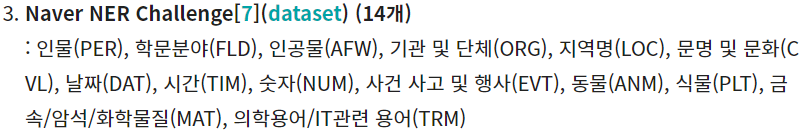

In [ ]:
dataset['ner_result'] = dataset['content'].apply(get_tags)

In [ ]:
dataset

# 2. ChatGPT API를 활용하여 NER Tagging 해보기

## Chat Response 추출

In [ ]:
#Open AI API키 입력

### Prompt 생성

(참고) Prompt 양식
- You are the assistant who extracts words from a given pop-up store-related sentence. The words to extract are as follows. 1. Brand name, 2. Product category 3. Location, 4. Period. In addition, the output form is provided in the form of json structure as follows. {"brandNm": (1.), "product": (2.), "location": (3.), "date": (4.)}.
- 당신은 정해진 팝업스토어 관련 문장에서 단어를 추출하는 어시스턴트입니다. 추출할 단어는 다음과 같습니다. 1. 브랜드명, 2. 상품 카테고리 3. 위치, 4. 기간. 또한 출력 형식은 다음과 같이 json 구조 형식으로 제공됩니다. {"brandNm": (1.), "product": (2.), "location": (3.), "date": (4.)}.

In [ ]:
def get_gpt(text) :
    messages = [
        {'role':'system', 'content':'You are the assistant who extracts words from a given pop-up store-related sentence. The words to extract are as follows. 1. Brand name, 2. Product category 3. Location, 4. Period. In addition, the output form is provided in the form of json structure as follows. {"brandNm": (1.), "product": (2.), "location": (3.), "date": (4.)}.'},
        {'role':'user', 'content':text}
    ]

    completion = openai.ChatCompletion.create(
        model = 'gpt-3.5-turbo',
        messages=messages
    )

    chat_response = completion.choices[0].message.content
    return chat_response

In [ ]:
# GPT 응답분 리셋
dataset['gpt_result'] = ''
dataset

,url,content,date,gpt_result
0,https://www.instagram.com/p/Cs5bRHjv8a-/,⏰ 팝가가 미리 알려주는 “업커밍 팝업스토어”⏰\n\n📝 Dr. GOT YOU 팝업...,2023-05-31,
1,https://www.instagram.com/p/CqejZt2Bfym/,💌4월 첫째 주 핫한 팝업 모음. zip💌\n\n✔️한달만 고깃집\n📍강남구 선릉로...,2023-04-01,
2,https://www.instagram.com/p/BwbZqTJgeID/,4/19~4/28 봄캠핑대전 in 벨라시타\n\n캠핑족을 부르는 캠핑대전 특가 팝업...,2019-04-19,
3,https://www.instagram.com/p/CYJKwfLpbC4/,🔥@yoonj_u 가 다녀오라고 했다! 르르르 하우스의 생생한 후기를 전하는 내발내...,2022-01-03,
4,https://www.instagram.com/p/CqehHInBwA7/,"🥓한달만 고깃집 팝업스토어🥓\n\nSNS 맛집 인플루언서, 피그웨이브와 꿉당이 만든...",2023-04-01,
...,...,...,...,...
882,https://www.instagram.com/p/CKdkXlKJ619/,달콤한 코랄핑크🎉치명적 귀여움 🎊무유무유\n\n다꾸의 일인자 무유무유가 돌아왔다! ...,2021-01-25,
883,https://www.instagram.com/p/B1a13jtJmsG/,#아슬란팝업스토어\n\n전국에 있는 빵덕후들 울산으로 다 모이는 소식😋🥖\n아슬란 ...,2019-08-21,
884,https://www.instagram.com/p/BzVbG6-AObv/,6/28~7/14 아크메드라비 in 롯데백화점 본점\n\n합리적인 가격의 브랜드 아...,2019-06-30,
885,https://www.instagram.com/p/BvNhjQDA7Mq/,3/15~4/14 선데이치즈볼 in 강남 카카오프렌즈\n\n못먹어본 사람은 있어도 ...,2019-03-20,


In [ ]:
# 완료되면 지우는 형식이라서 copy 사용.
dataset_gpt = dataset.copy()

In [ ]:
# df_popup = pd.DataFrame(columns=['brandNm', 'product', 'location', 'date', 'post_date']) #처음 시작 시 사용
df_popup = pd.read_csv("popup_info_df.csv", index_col=0, sep="|").dropna() #저장된 데이터가 있을 경우 사용
df_popup

,brandNm,product,location,date,post_date,origin_data_index
0,Dr. GOT YOU,식료품 및 굿즈,신세계 프리미엄 아울렛 여주점 EAST 광장,06.02(금)-06.11(일),2023-05-31,0.0
1,"['한달만 고깃집', 'KitKat Land', 'KANU HOUSE', 'Keds...","['음식점', '음식점', '음식점', '신발', '의류', '음식점', '전시',...","['강남구 선릉로155길 23-4 2층', '영등포구 국제금융로 10, IFC몰 L...","['03.15(수)-04.14(금)', '03.24(금)-04.02(일)', '03...",2023-04-01,1.0
2,타키,캠핑용품,벨라시타,4/19~4/28,2019-04-19,2.0
3,르르르 하우스,팝업스토어,마포구 와우산로23길 56,2021.12.24(금)-2022.01.07(금),2022-01-03,3.0
4,한달만고깃집,고깃집,강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,4.0
...,...,...,...,...,...,...
252,에고이스트,데님,롯데백화점 본점,3/29~4/14,2019-04-07,258.0
253,까사미아,리빙&라이프스타일,신세계백화점 강남,5/17~6/6,2019-05-27,259.0
254,"['르까레', '베이비블리', '코드먼츠']","['바디', '헤어', '색조', '아동브랜드', '핸드백', '시계', '가죽악세...",[],"['09.04', '-', '09.13', '09.07', '08.04', '-',...",2020-09-07,260.0
255,"['Hugging', 'Sliding to your life', '이게 무슨 일이야...",[],"['성동구 연무장17길 10', '성동구 연무장9길 7', '성동구 서울숲길 43 ...","['06.24(금)-07.07(목)', '06.30(목)-07.10(일)', '06...",2022-07-09,261.0


In [ ]:
already_index = list(set(df_popup['origin_data_index'].astype(int).to_list()))
dataset_gpt.drop(index=already_index, inplace=True)
dataset_gpt

,url,content,date,gpt_result
26,https://www.instagram.com/p/CX-uFocpop9/,🎾국내 첫 테니스 복합문화 공간 센트레코트 가로수 플레이달록가자!\n\n🔥압구정에 ...,2021-12-27,
108,https://www.instagram.com/p/CEBJTXdJ-Vb/,이번주 방문 할 만한\n⭐팝업맛집⭐\n⠀\n귀여운 일러스트 제품 #뚜까따 와\n감성...,2020-08-18,
116,https://www.instagram.com/p/CsKz-NtvSwc/,💌5월 둘째 주 핫한 팝업 모음. zip💌\n\n✔️막내사원 오리엔테이션\n📍강남구...,2023-05-13,
127,https://www.instagram.com/p/Cr4pkwqvqG9/,💌5월 첫째 주 핫한 팝업 모음. zip💌\n\n✔️프레시 샤워 룸\n📍성동구 연무...,2023-05-06,
134,https://www.instagram.com/p/BroO3ixAsFG/,12/15~05/31\n제주맥주 in 전포동\n\n서울 연남에 이어 부산 전포동에 ...,2018-12-21,
...,...,...,...,...
882,https://www.instagram.com/p/CKdkXlKJ619/,달콤한 코랄핑크🎉치명적 귀여움 🎊무유무유\n\n다꾸의 일인자 무유무유가 돌아왔다! ...,2021-01-25,
883,https://www.instagram.com/p/B1a13jtJmsG/,#아슬란팝업스토어\n\n전국에 있는 빵덕후들 울산으로 다 모이는 소식😋🥖\n아슬란 ...,2019-08-21,
884,https://www.instagram.com/p/BzVbG6-AObv/,6/28~7/14 아크메드라비 in 롯데백화점 본점\n\n합리적인 가격의 브랜드 아...,2019-06-30,
885,https://www.instagram.com/p/BvNhjQDA7Mq/,3/15~4/14 선데이치즈볼 in 강남 카카오프렌즈\n\n못먹어본 사람은 있어도 ...,2019-03-20,


#### API 호출
- Row당 최대 3번 반복하여 호출
- 매번 다른 대답이기 때문에, 전처리 시 오류처리 날 경우에는 새롭게 받음.

In [ ]:
for index, data in dataset_gpt[dataset_gpt['gpt_result']==''].iterrows() :
    print(f'Start.. Index : {index}')

    # 정상적으로 데이터를 받아 df_popup에 적재했다면, 3번 도는 for문과, Row별 도는 for문 모두를 나가야 하기 때문에 필요한 변수임.
    flag = False 

    for i in range(3) :
        print(f'Start.. Loop : {i}')

        try :
            test_text = get_gpt(data['content'])
        except :
            time.sleep(1)
            continue

        # 텍스트 전처리
        test_text.replace('\n', ' ') #Enter 제거
        test_text = re.sub('\s+', ' ', test_text) #연속 스페이스 제거

        # 딕셔너리 형태가 필요하므로 {로 시작하는 텍스트 부터 전처리 진행
        start_idx = test_text.find('{')
        if start_idx == -1 :
            continue
        else :
            test_text = test_text[start_idx:]

        # 딕셔너리 형태의 문자열이라면 json 파싱이 될 것!
        try :
            result = json.loads(test_text)
        except :
            continue

        result_arr = []
        if ((type(result['brandNm']) == list) and #value안에 여러개가 있을 때(ex. 5월 팝업 모음집)
            (result['location'] == list and result['date'] == list) and
            (len(result['brandNm']) == len(result['location']) == len(result['date']))) : #product를 제외하고는 모두 길이가 같을 경우에만 진행(GPT가 순서대로 넣었다는 가정 하에)

            tmp_dict = {}
            for i in range(len(result['brandNm'])) :
                tmp_dict = {
                    'brandNm' : result['brandNm'][i],
                    'product' : result['product'],
                    'location' : result['location'][i],
                    'date' : result['date'][i],
                }
                result_arr.apend(tmp_dict)
        else :
            result_arr.append(result)

        for each_result in result_arr :
            each_result = dict(zip(['brandNm', 'product', 'location', 'date'], list(each_result.values())))
            
            # Key값이 되는 브랜드이름이 없을 경우, Pass.
            if (not each_result['brandNm']) or (each_result['brandNm'] in ['None', 'null']) :
                continue

            each_result['post_date'] = data['date']
            each_result['origin_data_index'] = index
            df_popup = df_popup.append(each_result, ignore_index = True)
            flag = True

        if flag :
            dataset_gpt = dataset_gpt.drop(index, axis=0)
            break

    if flag :
        # 원 데이터에 결과값 저장
        dataset['gpt_result'][index] = each_result

        # csv Update
        df_popup.to_csv('popup_info_df.csv', sep='|')

Start.. Index : 26
Start.. Loop : 0
Start.. Index : 108
Start.. Loop : 0
Start.. Loop : 1
Start.. Index : 116
Start.. Loop : 0
Start.. Loop : 1
Start.. Loop : 2
Start.. Index : 127
Start.. Loop : 0
Start.. Index : 134
Start.. Loop : 0
Start.. Index : 142
Start.. Loop : 0
Start.. Loop : 1
Start.. Loop : 2
Start.. Index : 145
Start.. Loop : 0
Start.. Index : 184
Start.. Loop : 0
Start.. Index : 225
Start.. Loop : 0
Start.. Loop : 1
Start.. Loop : 2
Start.. Index : 254
Start.. Loop : 0
Start.. Loop : 1
Start.. Loop : 2
Start.. Index : 263
Start.. Loop : 0
Start.. Loop : 1
Start.. Index : 264
Start.. Loop : 0
Start.. Index : 265
Start.. Loop : 0
Start.. Index : 266
Start.. Loop : 0
Start.. Index : 267
Start.. Loop : 0
Start.. Index : 268
Start.. Loop : 0
Start.. Index : 269
Start.. Loop : 0
Start.. Index : 270
Start.. Loop : 0
Start.. Index : 271
Start.. Loop : 0
Start.. Index : 272
Start.. Loop : 0
Start.. Index : 273
Start.. Loop : 0
Start.. Index : 274
Start.. Loop : 0
Start.. Index : 2

In [ ]:
# csv로 저장
df_popup.to_csv('popup_info_df.csv', sep='|')
df_popup

,brandNm,product,location,date,post_date,origin_data_index
0,Dr. GOT YOU,식료품 및 굿즈,신세계 프리미엄 아울렛 여주점 EAST 광장,06.02(금)-06.11(일),2023-05-31,0.0
1,"['한달만 고깃집', 'KitKat Land', 'KANU HOUSE', 'Keds...","['음식점', '음식점', '음식점', '신발', '의류', '음식점', '전시',...","['강남구 선릉로155길 23-4 2층', '영등포구 국제금융로 10, IFC몰 L...","['03.15(수)-04.14(금)', '03.24(금)-04.02(일)', '03...",2023-04-01,1.0
2,타키,캠핑용품,벨라시타,4/19~4/28,2019-04-19,2.0
3,르르르 하우스,팝업스토어,마포구 와우산로23길 56,2021.12.24(금)-2022.01.07(금),2022-01-03,3.0
4,한달만고깃집,고깃집,강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,4.0
...,...,...,...,...,...,...
864,무유무유,팝업스토어,롯데몰 김포공항점,1.15(금) - 4.25(일),2021-01-25,882.0
865,아슬란,장산 마늘빵,현대백화점 울산점,8.16~8.22,2019-08-21,883.0
866,아크메드라비,패션,롯데백화점 본점,6/28~7/14,2019-06-30,884.0
867,카카오프렌즈,치즈볼,강남,3/15~4/14,2019-03-20,885.0


## 데이터 정제

In [ ]:
df_popup = pd.read_csv("popup_info_df.csv", index_col=0, sep="|")
df_popup

,brandNm,product,location,date,post_date,origin_data_index
0,Dr. GOT YOU,식료품 및 굿즈,신세계 프리미엄 아울렛 여주점 EAST 광장,06.02(금)-06.11(일),2023-05-31,0.0
1,"['한달만 고깃집', 'KitKat Land', 'KANU HOUSE', 'Keds...","['음식점', '음식점', '음식점', '신발', '의류', '음식점', '전시',...","['강남구 선릉로155길 23-4 2층', '영등포구 국제금융로 10, IFC몰 L...","['03.15(수)-04.14(금)', '03.24(금)-04.02(일)', '03...",2023-04-01,1.0
2,타키,캠핑용품,벨라시타,4/19~4/28,2019-04-19,2.0
3,르르르 하우스,팝업스토어,마포구 와우산로23길 56,2021.12.24(금)-2022.01.07(금),2022-01-03,3.0
4,한달만고깃집,고깃집,강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,4.0
...,...,...,...,...,...,...
864,무유무유,팝업스토어,롯데몰 김포공항점,1.15(금) - 4.25(일),2021-01-25,882.0
865,아슬란,장산 마늘빵,현대백화점 울산점,8.16~8.22,2019-08-21,883.0
866,아크메드라비,패션,롯데백화점 본점,6/28~7/14,2019-06-30,884.0
867,카카오프렌즈,치즈볼,강남,3/15~4/14,2019-03-20,885.0


### 복수 데이터 제거
- 하나의 Post에 여러개의 Row가 만들어질 수 없다는 가정
 - 위에서 브랜드명, 위치, 날짜의 추출된 데이터 개수가 모두 같다면 나눠서 넣어주긴 했음!
- 여러 건이면 제외한다 (추후 수동으로 분배할지도 생각)

In [ ]:
print(f'###### 전처리 전 데이터 개수 : {len(df_popup)}') #847

for index, data in df_popup.iterrows() :

    # 배열은 제외 (일단은..)
    for colNm in ['brandNm', 'location', 'date'] :
        if (str(data[colNm]).find('[')!=-1) and (str(data[colNm]).find(']')!=-1) :
            df_popup = df_popup.drop(index, axis=0)
            break

print(f'###### 전처리 후 데이터 개수 : {len(df_popup)}')

###### 전처리 전 데이터 개수 : 784
###### 전처리 후 데이터 개수 : 784


### date 컬럼
 - start_ymd, end_ymd date_diff로 분리 (시작일, 종료일, 기간)

In [ ]:
def extract_date(date_string) :

    date_string = re.sub('\s+', '', str(date_string)) #연속 스페이스 제거

    match0 = re.search(r'\d{2,4}[./-](\d{1,2})[./-](\d{1,2})\D+\d{2,4}[./-](\d{1,2})[./-](\d{1,2})', date_string)
    match1 = re.search(r'\d{2,4}[./-](\d{1,2})[./-](\d{1,2})\D+(\d{1,2})[./-](\d{1,2})', date_string)
    match2 = re.search(r'(\d{1,2})[./-](\d{1,2})\D+(\d{1,2})[./-](\d{1,2})', date_string)
    match3 = re.search(r'(\d{1,2})[월](\d{1,2})[일]\D+(\d{1,2})[월](\d{1,2})[일]', date_string)
    # match4 = re.search(r'(\d{1,2})[./-](\d{1,2})[~-](\d{1,2})$', date_string)

    # print("start!! "+date_string)

    all_date_arr = []

    if match0:
        for i in range(1, 5) :
            all_date_arr.append(match0.group(i))
    elif match1:
        for i in range(1, 5) :
            all_date_arr.append(match1.group(i))
    elif match2:
        for i in range(1, 5) :
            all_date_arr.append(match2.group(i))
    elif match3:
        for i in range(1, 5) :
            all_date_arr.append(match3.group(i))
    # elif match4:
    #     all_date_arr = [match4.group(1), match4.group(2), match4.group(1), match4.group(3)]
    else: 
        # print('out~')
        return None

    # print(all_date_arr)
    start_date = all_date_arr[0].zfill(2) + all_date_arr[1].zfill(2)
    end_date = all_date_arr[2].zfill(2) + all_date_arr[3].zfill(2)

    # print([start_date, end_date])

    return [start_date, end_date]

In [ ]:
print(f'###### 전처리 전 데이터 개수 : {len(df_popup)}') #670
df_popup['start_ymd'] = ''
df_popup['end_ymd'] = ''
df_popup['date_diff'] = ''
for index, data in df_popup.iterrows() :
    mmdd_arr = extract_date(data['date'])

    if not mmdd_arr : 
        continue
    
    if int(mmdd_arr[0][:2]) > int(mmdd_arr[1][:2]) :
        start_ymd = data['post_date'][:4]+mmdd_arr[0]
        end_ymd = str(int(data['post_date'][:4])+1)+mmdd_arr[1]
    else :
        start_ymd = data['post_date'][:4]+mmdd_arr[0]
        end_ymd = data['post_date'][:4]+mmdd_arr[1]

    try :
        start_ymd_tmp = datetime.strptime(start_ymd, "%Y%m%d")
        end_ymd_tmp = datetime.strptime(end_ymd, "%Y%m%d")
        date_diff = end_ymd_tmp - start_ymd_tmp

        if date_diff.days < 0 :
            print('error : '+str(index))
            continue

        # 데이터에 결과값 저장
        df_popup['start_ymd'][index] = start_ymd
        df_popup['end_ymd'][index] = end_ymd
        df_popup['date_diff'][index] = date_diff.days
    except : 
        continue
    
print(f'###### 전처리 후 데이터 개수 : {len(df_popup[df_popup["start_ymd"]!=""])}')

###### 전처리 전 데이터 개수 : 784
###### 전처리 후 데이터 개수 : 694


In [ ]:
# # 수기처리로 꾸역꾸역 넣기
# for index, data in df_popup[df_popup['start_ymd']==''].iterrows() :
#     print(data[['date','post_date']])
#     mmdd_arr = input("Input 'MMDD, MMDD' Here : ").split(',') # 수기처리
#     print('='*60)
    
#     if len(mmdd_arr) < 2 :
#         df_popup = df_popup.drop(index, axis=0)
#         continue
    
#     if int(mmdd_arr[0][:2]) > int(mmdd_arr[1][:2]) :
#         start_ymd = data['post_date'][:4]+mmdd_arr[0]
#         end_ymd = str(int(data['post_date'][:4])+1)+mmdd_arr[1]
#     else :
#         start_ymd = data['post_date'][:4]+mmdd_arr[0]
#         end_ymd = data['post_date'][:4]+mmdd_arr[1]

#     start_ymd_tmp = datetime.strptime(start_ymd, "%Y%m%d")
#     end_ymd_tmp = datetime.strptime(end_ymd, "%Y%m%d")
#     date_diff = end_ymd_tmp - start_ymd_tmp

#     if date_diff.days < 0 :
#         print('error : '+str(index))
    
#     # 데이터에 결과값 저장
#     df_popup['start_ymd'][index] = start_ymd
#     df_popup['end_ymd'][index] = end_ymd
#     df_popup['date_diff'][index] = date_diff.days

### 위치 컬럼
 - kakaoAPI로 검색 후 저장

In [ ]:
df_popup

,brandNm,product,location,date,post_date,origin_data_index,start_ymd,end_ymd,date_diff
0,Dr. GOT YOU,식료품 및 굿즈,신세계 프리미엄 아울렛 여주점 EAST 광장,06.02(금)-06.11(일),2023-05-31,0.0,20230602,20230611,9
2,타키,캠핑용품,벨라시타,4/19~4/28,2019-04-19,2.0,20190419,20190428,9
3,르르르 하우스,팝업스토어,마포구 와우산로23길 56,2021.12.24(금)-2022.01.07(금),2022-01-03,3.0,20221224,20230107,14
4,한달만고깃집,고깃집,강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,4.0,20230315,20230414,30
5,노우라이,바디 케어,성수,02.14(화)-03.19(일),2023-03-03,5.0,20230214,20230319,33
...,...,...,...,...,...,...,...,...,...
864,무유무유,팝업스토어,롯데몰 김포공항점,1.15(금) - 4.25(일),2021-01-25,882.0,20210115,20210425,100
865,아슬란,장산 마늘빵,현대백화점 울산점,8.16~8.22,2019-08-21,883.0,20190816,20190822,6
866,아크메드라비,패션,롯데백화점 본점,6/28~7/14,2019-06-30,884.0,20190628,20190714,16
867,카카오프렌즈,치즈볼,강남,3/15~4/14,2019-03-20,885.0,20190315,20190414,30


In [ ]:
api_key = '' # Kakao Api Key 입력
api = Local(service_key = api_key)

In [ ]:
def find_xy(loc_text) :

    # 괄호 제거
    loc_text = re.sub(r'\([^)]*\)', '', loc_text)

    # 층 정보 제거
    text_arr = loc_text.split()
    for each in text_arr :
        if each[-1:] == '층' :
            text_arr.remove(each)

    loc_text = ' '.join(text_arr)

    for i in range(3) :

        df_result = api.search_keyword(loc_text,  dataframe=True)

        # 검색 결과가 없으면
        if len(df_result) < 1 :
            tmp_arr = loc_text.split()
            
            # 너무 짧으면 그냥 리턴
            if len(tmp_arr) < 2 :
                return pd.DataFrame(['', '', '', ''])
            
            loc_text = ' '.join(tmp_arr[:-1])
        else :
            break
        
    result = df_result.loc[0]

    if result['road_address_name'] :
        address = result['road_address_name']
    else :
        address = result['address_name']

    return [result['place_name'], address, result['x'], result['y']]

In [ ]:
# 검색값 초기화
df_popup['address_name'] = ''
df_popup['address'] = ''
df_popup['x'] = ''
df_popup['y'] = ''

In [ ]:
# 주소 검색
for index, data in df_popup[df_popup['address']==''].iterrows() :

    try :
        result = find_xy(data['location'])
        print(f'============ now start idx : {index}')
        print(result)

        # 원 데이터에 결과값 저장
        df_popup['address_name'][index] = result[0]
        df_popup['address'][index] = result[1]
        df_popup['x'][index] = result[2]
        df_popup['y'][index] = result[3]
    except :
        continue

============ now start idx : 2
['벨라시타', '경기 고양시 일산동구 강송로 33', '126.79145164110946', '37.64205468429397']
============ now start idx : 3
['팝마트 플래그십 스토어', '서울 마포구 와우산로23길 56', '126.923789256948', '37.5552597685399']
============ now start idx : 4
['후추네', '서울 강남구 선릉로155길 23-4', '127.037434057379', '37.5254373129874']
============ now start idx : 5
['서울숲카페거리', '서울 성동구 성수동1가 668-11', '127.043028992489', '37.5464440372535']
============ now start idx : 6
['이태원거리', '서울 용산구 이태원동 119-23', '126.99580922812', '37.5345613066561']
============ now start idx : 7
['강남역 2호선 11번출구', '서울 강남구 역삼동 820-10', '127.02750296776951', '37.49883338787401']
============ now start idx : 10
['퍼시픽타워', '서울 중구 세종대로9길 41', '126.972990175293', '37.5613612035272']
============ now start idx : 11
['현대백화점 무역센터점', '서울 강남구 테헤란로 517', '127.05977475920854', '37.508651435836725']
============ now start idx : 12
['갤러리아백화점 WEST점', '서울 강남구 압구정로 343', '127.04014394421372', '37.52842774945761']
============ now start idx : 13
['배스킨라빈

In [ ]:
con1 = (df_popup['address']!='') & (df_popup["start_ymd"]!='')
len(df_popup[con1])

665

- 아직 괜찮다고 판단. 필요할 경우 date 및 location 전처리에서 제거된 데이터를 수기로 설정해줄 필요가 있어보임.

In [ ]:
df_popup[['x', 'y']] = df_popup[['x', 'y']].astype(float)

In [ ]:
df_popup = df_popup[con1]
df_popup

,brandNm,product,location,date,post_date,origin_data_index,start_ymd,end_ymd,date_diff,address_name,address,x,y
0,Dr. GOT YOU,식료품 및 굿즈,신세계 프리미엄 아울렛 여주점 EAST 광장,06.02(금)-06.11(일),2023-05-31,0.0,20230602,20230611,9,신세계프리미엄아울렛 여주 EAST,경기 여주시 명품로 360,127.612990,37.242171
2,타키,캠핑용품,벨라시타,4/19~4/28,2019-04-19,2.0,20190419,20190428,9,벨라시타,경기 고양시 일산동구 강송로 33,126.791452,37.642055
3,르르르 하우스,팝업스토어,마포구 와우산로23길 56,2021.12.24(금)-2022.01.07(금),2022-01-03,3.0,20221224,20230107,14,팝마트 플래그십 스토어,서울 마포구 와우산로23길 56,126.923789,37.555260
4,한달만고깃집,고깃집,강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,4.0,20230315,20230414,30,후추네,서울 강남구 선릉로155길 23-4,127.037434,37.525437
5,노우라이,바디 케어,성수,02.14(화)-03.19(일),2023-03-03,5.0,20230214,20230319,33,서울숲카페거리,서울 성동구 성수동1가 668-11,127.043029,37.546444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,무유무유,팝업스토어,롯데몰 김포공항점,1.15(금) - 4.25(일),2021-01-25,882.0,20210115,20210425,100,롯데몰 김포공항점,서울 강서구 하늘길 지하 77,126.803148,37.563366
865,아슬란,장산 마늘빵,현대백화점 울산점,8.16~8.22,2019-08-21,883.0,20190816,20190822,6,현대백화점 울산점,울산 남구 삼산로 261,129.335747,35.539595
866,아크메드라비,패션,롯데백화점 본점,6/28~7/14,2019-06-30,884.0,20190628,20190714,16,롯데백화점 본점,서울 중구 남대문로 81,126.981754,37.564906
867,카카오프렌즈,치즈볼,강남,3/15~4/14,2019-03-20,885.0,20190315,20190414,30,압구정로데오거리,서울 강남구 신사동 668-33,127.039152,37.526756


In [ ]:
# csv로 저장
df_popup.to_csv('popup_info_df.csv', sep='|')

### 동일값 판단하여 제거
- 기준
 - 브랜드 이름이 같고, 위치가 같은 경우
 - 브랜드 이름이 같고, 날짜가 같은 경우

### 브랜드 이름을 기준으로 유사한 값 제거
 - 코사인 유사도를 통해 동일한 것으로 판단되는 데이터를 삭제한다.
 - 기준 : 유사도 0.8 이상인 데이터를 나열 후, 사람이 판단하여 해당 인덱스를 제거

In [ ]:
def similar(a, b) :
    return SequenceMatcher(None, a, b).ratio()

#### 적정한 코사인 유사도 정의를 위한 테스트

In [ ]:
for rat in np.arange(0.1, 1.1, 0.1) :
    rat = round(rat, 1)
    COS_RATIO = rat

    cnt = 0
    for index, data in df_popup.iterrows() :
        df_sim = pd.DataFrame(columns=['similar'])
        df_sim['similar'] = df_popup['brandNm'][(index+1):].apply(similar, args=[data['brandNm']]) #유사도 계산
        df_sim = df_sim[df_sim['similar']>=COS_RATIO]
        df_sim = df_sim.sort_values(by=['similar'], ascending=False)

        if len(df_sim) > 0 :
            cnt += 1
            # print(data['brandNm'])
            # display(df_popup.loc[df_sim.index][['brandNm']])

    print(f'설정한 코사인 유사도 : {COS_RATIO} => 결과 건수 : {cnt}')

설정한 코사인 유사도 : 0.1 => 결과 건수 : 483
설정한 코사인 유사도 : 0.2 => 결과 건수 : 474
설정한 코사인 유사도 : 0.3 => 결과 건수 : 367
설정한 코사인 유사도 : 0.4 => 결과 건수 : 264
설정한 코사인 유사도 : 0.5 => 결과 건수 : 165
설정한 코사인 유사도 : 0.6 => 결과 건수 : 66
설정한 코사인 유사도 : 0.7 => 결과 건수 : 53
설정한 코사인 유사도 : 0.8 => 결과 건수 : 43
설정한 코사인 유사도 : 0.9 => 결과 건수 : 40
설정한 코사인 유사도 : 1.0 => 결과 건수 : 39


#### 제거 진행

In [ ]:
from haversine import haversine

a = (df_popup.loc[0, 'y'], df_popup.loc[0, 'x'])
b = (df_popup.loc[2, 'y'], df_popup.loc[2, 'x'])
print(a)
haversine(a, b, unit='km')

(37.24217050143996, 127.61298983008768)


85.07423610736377

In [ ]:
def dist_cal(data, standard_xy) :
    comp_xy = (data['y'], data['x'])
    return haversine(comp_xy, standard_xy, unit='km')

In [ ]:
print(f'###### 전처리 전 데이터 개수 : {len(df_popup)}') #573

COS_RATIO = 0.6

for index, data in df_popup.iterrows() :
    
    # 브랜드 이름의 유사도 계산
    df_sim = pd.DataFrame(columns=['similar'])
    df_sim['similar'] = df_popup['brandNm'].apply(similar, args=[data['brandNm']]) #유사도 계산
    df_sim.drop(index, axis=0, inplace=True)
    df_sim = df_sim[df_sim['similar']>=COS_RATIO]
    df_sim = df_sim.sort_values(by=['similar'], ascending=False)

    if len(df_sim) < 1 :
        continue

    df_comp = df_popup.loc[df_sim.index]
    
    #날짜
    con1 = df_comp['start_ymd'] == data['start_ymd']
    con2 = df_comp['end_ymd'] == data['end_ymd']

    if df_comp[con1&con2].empty :
        continue

    #위치
    standard = (data['y'], data['x'])
    df_comp['distance'] = df_comp[['x','y']].apply(dist_cal, args=[standard], axis=1)

    if df_comp[df_comp['distance']<=1.0].empty :
        continue
    
    df_popup.drop(index, axis=0, inplace=True)

print(f'###### 전처리 후 데이터 개수 : {len(df_popup)}')

###### 전처리 전 데이터 개수 : 665
###### 전처리 후 데이터 개수 : 661


In [ ]:
#최종 정보이므로 인덱스 리셋
df_popup.reset_index(drop=True, inplace=True)
df_popup.index.name = 'id'

# csv로 저장
df_popup.to_csv('popup_info_df.csv', sep='|')

# KakaoAPI로 주변 정보 가져오기

In [ ]:
api_key = '' # Kakao Api Key 입력
api = Local(service_key = api_key)

In [ ]:
df_popup = pd.read_csv("popup_info_df.csv", index_col=0, sep="|")
df_popup

,brandNm,product,location,date,post_date,origin_data_index,start_ymd,end_ymd,date_diff,address_name,address,x,y
id,,,,,,,,,,,,,
0,Dr. GOT YOU,식료품 및 굿즈,신세계 프리미엄 아울렛 여주점 EAST 광장,06.02(금)-06.11(일),2023-05-31,0.0,20230602,20230611,9,신세계프리미엄아울렛 여주 EAST,경기 여주시 명품로 360,127.612990,37.242171
1,타키,캠핑용품,벨라시타,4/19~4/28,2019-04-19,2.0,20190419,20190428,9,벨라시타,경기 고양시 일산동구 강송로 33,126.791452,37.642055
2,르르르 하우스,팝업스토어,마포구 와우산로23길 56,2021.12.24(금)-2022.01.07(금),2022-01-03,3.0,20221224,20230107,14,팝마트 플래그십 스토어,서울 마포구 와우산로23길 56,126.923789,37.555260
3,한달만고깃집,고깃집,강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,4.0,20230315,20230414,30,후추네,서울 강남구 선릉로155길 23-4,127.037434,37.525437
4,노우라이,바디 케어,성수,02.14(화)-03.19(일),2023-03-03,5.0,20230214,20230319,33,서울숲카페거리,서울 성동구 성수동1가 668-11,127.043029,37.546444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,무유무유,팝업스토어,롯데몰 김포공항점,1.15(금) - 4.25(일),2021-01-25,882.0,20210115,20210425,100,롯데몰 김포공항점,서울 강서구 하늘길 지하 77,126.803148,37.563366
657,아슬란,장산 마늘빵,현대백화점 울산점,8.16~8.22,2019-08-21,883.0,20190816,20190822,6,현대백화점 울산점,울산 남구 삼산로 261,129.335747,35.539595
658,아크메드라비,패션,롯데백화점 본점,6/28~7/14,2019-06-30,884.0,20190628,20190714,16,롯데백화점 본점,서울 중구 남대문로 81,126.981754,37.564906


## 지하철역, 주차장, 음식점, 카페 정보 가져오기

In [ ]:
df_subway = pd.DataFrame(columns=['id', 'subway_name', 'subway_line', 'distance', 'x', 'y'])
df_peri_info = pd.DataFrame(columns=['id', 'category', 'place_name', 'distance', 'x', 'y'])

for index, data in tqdm(df_popup.iterrows(), total=len(df_popup)) :
    # 주변 지하철역
    # 1km 반경
    result =  api.search_category('SW8', x=data['x'], y=data['y'], radius=1000, dataframe=True)

    if not result.empty :
        # 데이터셋 정제
        result = result[['distance', 'place_name', 'x', 'y']]
        result['subway_name'] = result.place_name.str.split(' ').str[0]
        result['subway_line'] = result.place_name.str.split(' ').str[1]
        result.drop(['place_name'], axis='columns', inplace=True)
        result['distance'] = result['distance'].astype(int)
        result['id'] = index
        result.sort_values(by='subway_name', inplace=True)
        df_subway = pd.concat([df_subway, result], ignore_index=True)
    
    result1 = api.search_category('PK6', x=data['x'], y=data['y'], radius=1000, size=5, dataframe=True) # 주변 주차장
    result2 = api.search_category('FD6', x=data['x'], y=data['y'], radius=1000, size=5, dataframe=True) # 주변 음식점
    result3 = api.search_category('CE7', x=data['x'], y=data['y'], radius=1000, size=5, dataframe=True) # 주변 카페

    df_tmp = pd.concat([result1, result2, result3], ignore_index=True)

    if not df_tmp.empty :
        df_tmp = df_tmp[['category_group_code', 'distance', 'place_name', 'x', 'y']]
        df_tmp.rename(columns={'category_group_code':'category'}, inplace=True)
        df_tmp['id'] = index
        df_peri_info = pd.concat([df_peri_info, df_tmp], ignore_index=True)

100%|██████████| 661/661 [36:04<00:00,  3.28s/it]


In [ ]:
df_peri_info

,id,category,place_name,distance,x,y
0,0,PK6,여주프리미엄아울렛 B주차장,155,127.613596810081,37.2408599608713
1,0,PK6,신세계프리미엄아울렛 여주점 주차장A,246,127.6125798892741,37.239978610517596
2,0,PK6,여주프리미엄아울렛 D주차장,91,127.613671102469,37.2427949917445
3,0,PK6,여주프리미엄아울렛 E주차장,322,127.612697684921,37.2450634230512
4,0,PK6,여주프리미엄아울렛 H주차장,422,127.609135538444,37.2399423162801
...,...,...,...,...,...,...
9858,660,CE7,놀숲 송파구청점,436,127.108768686634,37.5149739660108
9859,660,CE7,놀숲 송파점,876,127.108525721995,37.5065371874882
9860,660,CE7,라라브레드 송파점,518,127.10910244054197,37.511138986438866
9861,660,CE7,뉴질랜드스토리,459,127.105842950648,37.509703949514


In [ ]:
# csv로 저장
df_subway.to_csv('df_subway.csv', sep='|')
df_peri_info.to_csv('df_peri_info.csv', sep='|')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-80-3c26f1068045>", line 2, in <cell line: 2>
    df_subway.to_csv('df_subway.csv', sep='|')
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 3720, in to_csv
    return DataFrameRenderer(formatter).to_csv(
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py", line 1189, in to_csv
    csv_formatter.save()
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/formats/csvs.py", line 241, in save
    with get_handle(
  File "/usr/local/lib/python3.10/dist-packages